In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
from sklearn.covariance import LedoitWolf

### Forex Data Processing

In [106]:
fx_raw = pd.read_csv("FX_rates.csv", header=3)

fx_raw = fx_raw.rename(columns={"Time Period": "Date"})
fx_raw["Date"] = pd.to_datetime(fx_raw["Date"])
fx_raw = fx_raw.set_index("Date")

meta = pd.read_csv("FX_rates.csv", nrows=3)
currency_row = meta.iloc[2, 1:].values  


cols = fx_raw.columns
fx_temp = fx_raw.copy()


for i, col in enumerate(cols):
    fx_currency = currency_row[i]

    if fx_currency == "USD":
        continue
    else:
        fx_temp[col] = 1 / fx_temp[col]

# fx_col_to_country = {
#     "RXI$US_N.M.AL": "AUSTRALIA",
#     "RXI$US_N.M.EU": "EURO AREA",
#     "RXI$US_N.M.NZ": "NEW ZEALAND",
#     "RXI$US_N.M.UK": "United Kingdom",
#     "RXI_N.M.BZ": "BRAZIL",
#     "RXI_N.M.CA": "CANADA",
#     "RXI_N.M.CH": "CHINA",
#     "RXI_N.M.DN": "DENMARK",
#     "RXI_N.M.IN": "INDIA",
#     "RXI_N.M.JA": "JAPAN",
#     "RXI_N.M.MX": "MEXICO",
#     "RXI_N.M.NO": "NORWAY",
#     "RXI_N.M.SF": "SOUTH AFRICA",
#     "RXI_N.M.SI": "Singapore",
#     "RXI_N.M.KO": "KOREA",
#     "RXI_N.M.SD": "SWEDEN",
#     "RXI_N.M.SZ": "SWITZERLAND",
#     "RXI_N.M.TA": "TAIWAN"
# }
# fx_temp = fx_temp.rename(columns=fx_col_to_country)

delta_s = np.log(fx_temp).diff().dropna().round(6)

#### Risk Free Interest Data Proceasing

In [107]:
rf_raw = pd.read_csv("Risk Free Rates.csv")
rf_raw["M1"] = pd.to_datetime(rf_raw["M1"], format="%Y%m%d")
rf_raw = rf_raw.set_index("M1")

rf_clean = rf_raw.apply(pd.to_numeric, errors="coerce")
rf_clean.head()

rf_monthly = rf_clean.resample('ME').mean().round(6).reset_index()
rf_monthly["M1"] = rf_monthly["M1"].dt.to_period("M")
rf_monthly.to_csv("risk_free_monthly.csv", index=False)

#### Excess Forex Returns 

In [108]:
usd_rf = rf_monthly["R_USD"]  # domestic rate

fx_to_rf_map = {
    "AUSTRALIA": "R_AUD",
    "EURO AREA": "R_EUR",
    "NEW ZEALAND": "R_NZD",
    "United Kingdom": "R_GBP",
    "BRAZIL": "R_BRL",
    "CANADA": "R_CAD",
    "CHINA": "R_CNY",
    "DENMARK": "R_DKK",
    "INDIA": "R_INR",
    "JAPAN": "R_JPY",
    "MEXICO": "R_MXN",
    "NORWAY": "R_NOK",
    "SOUTH AFRICA": "R_ZAR",
    "Singapore": "R_SGD",
    "KOREA": "R_KRW",
    "SWEDEN": "R_SEK",
    "SWITZERLAND": "R_CHF",
    "TAIWAN": "R_TWD"
}

excess_returns = delta_s.copy()

for fx_col, rf_col in fx_to_rf_map.items():
    if fx_col in excess_returns.columns and rf_col in rf_monthly.columns:
        i_for = rf_monthly[rf_col]
        i_dom = usd_rf
        # Only calculate if foreign rate is not NaN
        mask = i_for.notna()
        excess_returns.loc[mask, fx_col] = (i_for[mask] - i_dom[mask]) - delta_s.loc[mask, fx_col]
        # Leave NaN where foreign rate is missing
        excess_returns.loc[~mask, fx_col] = np.nan

excess_returns.to_csv("FX_excess_returns.csv")

## Full-Sample Markowitz Tangency Portfolio (With efficient frontier + cumulative return plot)

Full-Sample Tangency Weights (Shorting Allowed):
[-0.12096394  0.06319956 -0.01054058  0.35430957 -0.16064427  0.22693132
  0.49512819 -0.11508207 -0.69059009 -0.61206981 -0.09196897 -0.19499085
 -0.13320533  1.55828459  0.04001626 -0.16467439  0.72144747 -0.16458668]


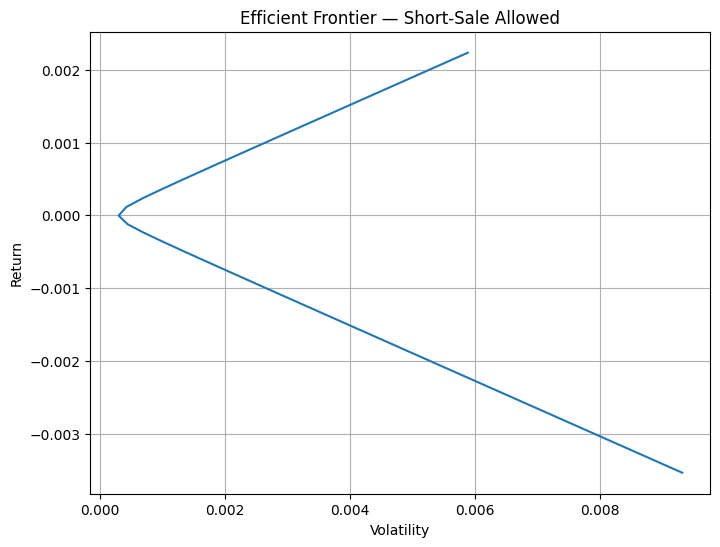

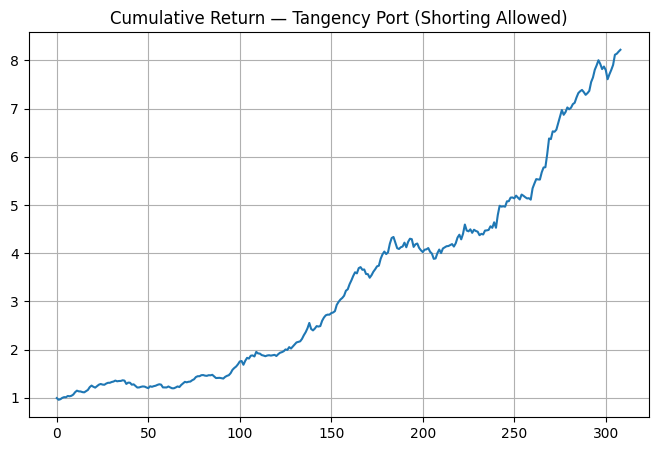

In [ ]:
# Numpy Prepare Inputs (ensure numpy arrays)
mu = excess_returns.mean().values          
cov = excess_returns.cov().values          

# ------------------------------------------------------
# Tangency Portfolio (Shorting Allowed)
# ------------------------------------------------------
def markowitz_tangency(mu, cov):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(len(mu))

    # w ∝ Σ^{-1} μ , then scale to sum to 1
    w = inv_cov @ mu
    w = w / (ones @ w)
    return w

w_full = markowitz_tangency(mu, cov)

print("Full-Sample Tangency Weights (Shorting Allowed):")
print(w_full)


# ------------------------------------------------------
# Efficient Frontier (Short-Sale Allowed)
# ------------------------------------------------------
def efficient_frontier(mu, cov, points=50):
    mu = mu.reshape(-1, 1)
    ones = np.ones((len(mu), 1))
    inv_cov = np.linalg.inv(cov)

    A = ones.T @ inv_cov @ ones     # scalar
    B = ones.T @ inv_cov @ mu       # scalar
    C = mu.T @ inv_cov @ mu         # scalar
    D = A*C - B**2                  # scalar

    target_returns = np.linspace(mu.min(), mu.max(), points)

    vols = []
    rets = []

    for r in target_returns:
        r = float(r)

        w = ((C - B*r)/D) * (inv_cov @ ones) + ((A*r - B)/D) * (inv_cov @ mu)
        w = w.flatten()

        vol = np.sqrt(w.T @ cov @ w)

        vols.append(vol)
        rets.append(r)

    return vols, rets

sigma, ret_list = efficient_frontier(mu, cov)

plt.figure(figsize=(8,6))
plt.plot(sigma, ret_list)
plt.title("Efficient Frontier — Short-Sale Allowed")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.grid(True)
plt.show()


# ------------------------------------------------------
# Cumulative Return of Tangency Portfolio
# ------------------------------------------------------
full_sample_portfolio_returns = excess_returns.values @ w_full
cum = (1 + full_sample_portfolio_returns).cumprod()

plt.figure(figsize=(8,5))
plt.plot(cum)
plt.title("Cumulative Return — Tangency Port (Shorting Allowed)")
plt.grid(True)
plt.show()

## Rolling Sample Markowitz Portfolio

In [110]:
# Tangency portfolio (short selling allowed)

def markowitz_tangency(mu, cov):
    mu = np.asarray(mu).reshape(-1)
    cov = np.asarray(cov)
    inv_cov = np.linalg.inv(cov)

    ones = np.ones(len(mu))

    w = inv_cov @ mu
    w = w / (ones @ w)   # budget constraint 1'w = 1

    return w

# Rolling Out-of-Sample Evaluation

window = 60
rets = excess_returns.copy()
oos = []

for t in tqdm(range(window, len(rets) - 1)):

    sample = rets.iloc[t-window:t]

    # convert to numpy
    mu_t = sample.mean().values
    cov_t = sample.cov().values

    # tangency weights (short selling allowed)
    w_t = markowitz_tangency(mu_t, cov_t)

    # next-period return
    r_next = np.dot(rets.iloc[t+1].values, w_t)
    oos.append(r_next)

rolling_markowitz = pd.Series(oos, index=rets.index[window+1:])

100%|██████████| 248/248 [00:00<00:00, 5844.37it/s]


## Naive 1/N Portfolio

In [111]:
# number of assets
N = excess_returns.shape[1]

# equal weights, short selling allowed
# (weights sum to 1, no sign restrictions needed)
w_equal = np.ones(N) / N

# out-of-sample returns aligned after 60-month window
naive_returns = (excess_returns @ w_equal).iloc[60:]

## Ledoit–Wolf Shrinkage Portfolio

In [112]:
window = 60
rets = excess_returns.copy()

oos_lw = []

for t in tqdm(range(window, len(rets)-1)):

    # sample window
    sample = rets.iloc[t-window:t]

    # mean vector
    mu_t = sample.mean().values

    # Ledoit–Wolf shrinkage covariance
    lw = LedoitWolf().fit(sample.values)
    cov_t = lw.covariance_

    # ---------- Tangency Portfolio (short-selling allowed) ----------
    inv_cov = np.linalg.inv(cov_t)
    w = inv_cov @ mu_t

    # budget constraint: 1'w = 1 (no sign restrictions)
    w = w / (np.ones(len(mu_t)) @ w)

    # next-period return
    r_next = np.dot(rets.iloc[t+1].values, w)
    oos_lw.append(r_next)

lw_returns = pd.Series(oos_lw, index=rets.index[window+1:])

100%|██████████| 248/248 [00:00<00:00, 2660.20it/s]


## Constrained Markowitz (CVXPY)

In [113]:

# Tangency portfolio via mean-variance optimization
# Short-selling allowed, only sum(w)=1

def cvxpy_tangency(mu, cov, gamma=1e-6):
    n = len(mu)
    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - gamma * cp.quad_form(w, cov))
    constraints = [cp.sum(w) == 1]   # short-selling allowed → no bounds

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    # normalize in case solver drifts slightly
    w_val = w.value
    return w_val / w_val.sum()


# Rolling out-of-sample

window = 60
rets = excess_returns.copy()
oos_cvx = []

for t in tqdm(range(window, len(rets)-1)):
    sample = rets.iloc[t-window:t]

    mu_t = sample.mean().values
    cov_t = sample.cov().values

    # short-selling allowed CVXPY tangency
    w_t = cvxpy_tangency(mu_t, cov_t)

    # next-month return
    r_next = np.dot(rets.iloc[t+1].values, w_t)
    oos_cvx.append(r_next)

cvx_returns = pd.Series(oos_cvx, index=rets.index[window+1:])

  0%|          | 0/248 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 41%|████      | 102/248 [00:02<00:02, 50.84it/s]


AttributeError: 'NoneType' object has no attribute 'sum'

## Resampled (Bootstrap) Michaud Portfolio

In [114]:
# Bootstrap Tangency Weights
# Short-selling allowed (no bounds)

def bootstrap_weights(sample, B=500):
    """
    Compute resampled tangency portfolio weights (Michaud)
    Short-selling allowed.
    
    sample : pd.DataFrame : window of returns
    B : int : number of bootstrap samples
    """
    N = sample.shape[1]
    weights = []

    for _ in range(B):
        # bootstrap indices
        idx = np.random.choice(len(sample), size=len(sample), replace=True)
        boot = sample.iloc[idx]

        # sample mean and cov
        mu_b = boot.mean().values
        cov_b = boot.cov().values

        # ensure covariance is invertible
        try:
            w_b = np.linalg.inv(cov_b) @ mu_b
            # normalize weights to sum to 1
            w_b = w_b / np.sum(w_b)
            weights.append(w_b)
        except np.linalg.LinAlgError:
            continue

    return np.mean(weights, axis=0)



# Rolling Out-of-Sample Portfolio

window = 60
rets = excess_returns.copy()
oos_boot = []

for t in tqdm(range(window, len(rets)-1)):
    sample = rets.iloc[t-window:t]

    # bootstrap average weights
    w_bar = bootstrap_weights(sample, B=300)

    # next-month return
    r_next = np.dot(rets.iloc[t+1].values, w_bar)
    oos_boot.append(r_next)

boot_returns = pd.Series(oos_boot, index=rets.index[window+1:])

100%|██████████| 248/248 [00:09<00:00, 25.17it/s]


## Rolling Sharpe Ratio Plot

NameError: name 'cvx_returns' is not defined

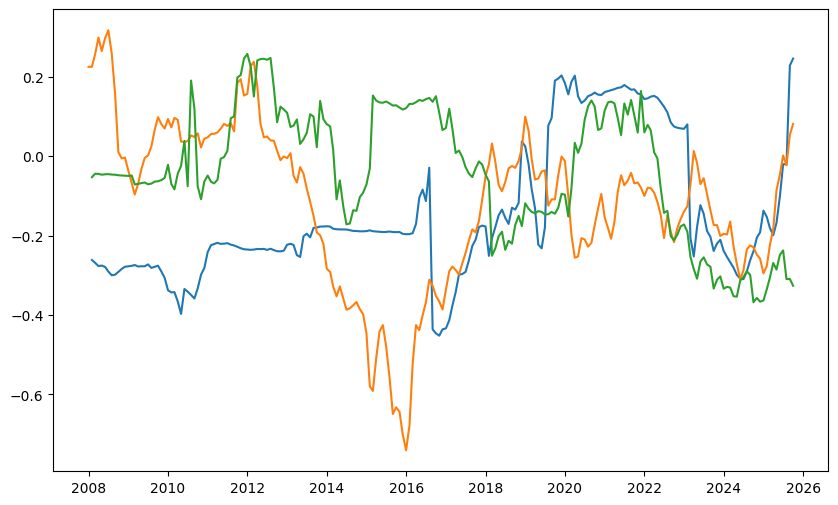

In [115]:
def rolling_sharpe(return_series, window=36):
    return (return_series.rolling(window).mean() /
            return_series.rolling(window).std())

plt.figure(figsize=(10,6))
plt.plot(rolling_sharpe(rolling_markowitz), label="Sample Markowitz")
plt.plot(rolling_sharpe(naive_returns), label="Naive 1/N")
plt.plot(rolling_sharpe(lw_returns), label="Ledoit-Wolf")
plt.plot(rolling_sharpe(cvx_returns), label="CVXPY Constrained")
plt.plot(rolling_sharpe(boot_returns), label="Bootstrap Resampled")
plt.legend()
plt.title("Rolling Sharpe Ratios (36-month window)")
plt.grid(True)
plt.show()

## Cumulative Return Plot for All Methods

NameError: name 'cvx_returns' is not defined

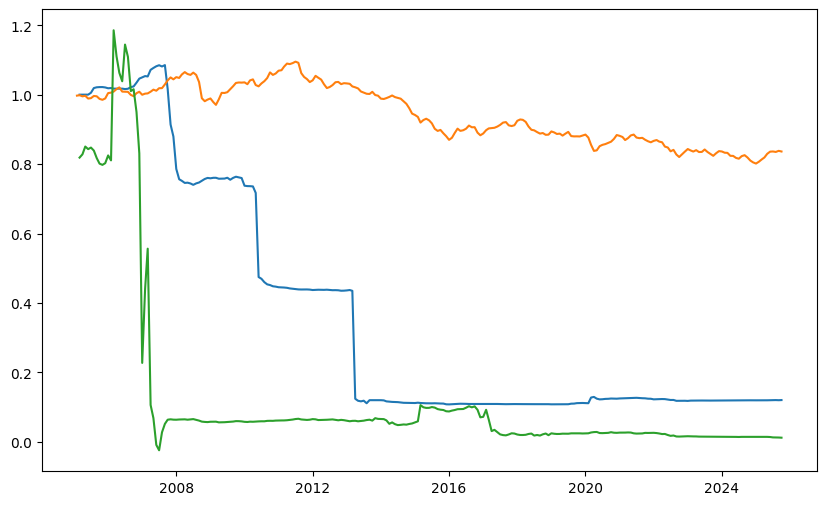

In [116]:
plt.figure(figsize=(10,6))
plt.plot((1+rolling_markowitz).cumprod(), label="Rolling Markowitz")
plt.plot((1+naive_returns).cumprod(), label="Naive 1/N")
plt.plot((1+lw_returns).cumprod(), label="Ledoit-Wolf")
plt.plot((1+cvx_returns).cumprod(), label="Constrained CVXPY")
plt.plot((1+boot_returns).cumprod(), label="Resampled")
plt.legend()
plt.title("Cumulative Returns — All Strategies")
plt.grid(True)
plt.show()